In [8]:
import csv
import re
import string
from collections import Counter

import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [9]:
# read data from CSV file
with open('fampay_instagram_data.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    posts = [row for row in reader]

In [10]:
def preprocess_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'\d+', '', text) # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    tokens = word_tokenize(text) # tokenize text
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # lemmatize words
    tokens = [token for token in tokens if token not in stop_words] 
    return ' '.join(tokens)

In [11]:
# preprocess captions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
captions = [preprocess_text(post['caption']) for post in posts]

In [12]:
# create TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(captions)

In [13]:
# perform clustering with K-Means
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(tfidf_matrix)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=0)

In [14]:
# analyze clusters
cluster_labels = kmeans.labels_
cluster_engagements = Counter()
for i, post in enumerate(posts):
    cluster_engagements[cluster_labels[i]] += int(post['num_likes']) + int(post['num_comments'])

In [15]:
# print top 5 captions in each cluster
print('Top 5 captions in each cluster:')
for i in range(num_clusters):
    cluster_posts = [post for j, post in enumerate(posts) if cluster_labels[j] == i]
    cluster_posts_sorted = sorted(cluster_posts, key=lambda post: int(post['num_likes']) + int(post['num_comments']), reverse=True)
    print(f'\nCluster {i} ({len(cluster_posts)} posts):')
    for j, post in enumerate(cluster_posts_sorted[:5]):
        print(f'{j+1}. {post["caption"]}')

Top 5 captions in each cluster:

Cluster 0 (117 posts):
1. when you like this 🥳
when you share this 🕺💃
2. 30k likes and we reveal the next steps 🔎
3. get us 35k likes on this post and we’ll asli mei make and send these hoodies to some of you 😎🤙
4. 1 like = 1 good luck bro
5. share this with ‘that’ friend to get your money back 🤓

Cluster 1 (335 posts):
1. remember at the end of the day: aaaall is well 🫶
2. forget them, they’re hissstory 🤭
3. Tap the calendar icon and spam the chat with 🎮 if you wanna be our Chief Gaming Officer! Lessgo 🎯
4. 🎁🎁🎁🤩✨
5. share these cakes with your friends 🎂👍🏻

Cluster 2 (70 posts):
1. UPGRADE to iPhone 14 in 2023! - bass recharge for ₹99+ on FamPay. Jitne zyada recharges, utne zyada chances of winning! 

Oh also - sabko milega up to ₹50 cash reward and 50 lucky winners will win 1 Year Disney+ Hotstar subscription 🔥
2. manifesting a T20 World Cup win for India 🇮🇳🇮🇳🇮🇳 andddd you watching it for FREE

To win
1️⃣ recharge your phone on FamPay for a minimum of 

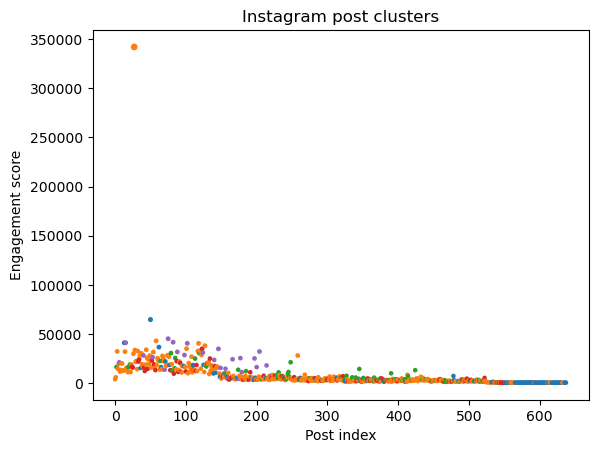

In [16]:
# plot clusters
engagements = [int(post['num_likes']) + int(post['num_comments']) for post in posts]
sizes = [10 * (engagement - min(engagements)) / (max(engagements) - min(engagements)) + 5 for engagement in engagements]
colors = [f'C{i}' for i in cluster_labels]
plt.scatter(range(len(posts)), engagements, c=colors, s=sizes)
plt.xlabel('Post index')
plt.ylabel('Engagement score')
plt.title('Instagram post clusters')
plt.show()


In [17]:
# save all data to a new CSV file for further analysis
with open('fampay_instagram_data_with_clusters.csv', 'w', newline='') as csvfile:
    fieldnames = ['caption', 'num_likes', 'num_comments', 'cluster']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i, post in enumerate(posts):
        writer.writerow({
            'caption': post['caption'],
            'num_likes': post['num_likes'],
            'num_comments': post['num_comments'],
            'cluster': cluster_labels[i]
        })

# save cluster data to a new CSV file for further analysis
with open('fampay_instagram_clusters.csv', 'w', newline='') as csvfile:
    fieldnames = ['cluster', 'num_posts', 'engagement_score']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_clusters):
        writer.writerow({
            'cluster': i,
            'num_posts': len([post for j, post in enumerate(posts) if cluster_labels[j] == i]),
            'engagement_score': cluster_engagements[i]
        })

pickle.dump(kmeans, open('kmeans_model.sav', 'wb'))